# Deep Learning &mdash; Assignment 6

Sixth assignment for the 2023 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:** Andrew Schroeder and Fynn Gerding

**Group:** 17

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Construct a PyTorch `DataSet`.
1. Train and modify a transformer network.
1. Learn how to use a model based on the PyTorch documentation.
1. Experiment with a translation dataset.

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` for PyTorch,

All libraries can be installed with `pip install`.

In [5]:
%matplotlib inline
import math
import time
from random import Random
from typing import (List, Optional)
import numpy as np
import torch
from torch import nn
from torch.utils.data import (IterableDataset, DataLoader)
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd

# fix the seed, so outputs are exactly reproducible
torch.manual_seed(12345);

# Use the GPU if available
def detect_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
device = detect_device()
device = 'cpu'

## 6.1 Learning to calculate (5 points)

In this assignment we are going to train a neural network to do mathematics.
When communicating between humans, mathematics is expressed with words and formulas.
The simplest of these are formulas with a numeric answer. For example, we might ask what is `100+50`, to which the answer is `150`.

To teach a computer how to do this task, we are going to need a dataset.

Below is a function that generates a random formula. Study it, and see if you understand its parameters.

In [6]:
def random_integer(length: int, signed: bool = True, rng: Random = Random()):
    max = int(math.pow(10, length))
    min = -max if signed else 0
    return rng.randint(min, max)

def random_formula(complexity: int, signed: bool = True, rng: Random = Random()):
    """
    Generate a random formula of the form "a+b" or "a-b".
    complexity is the maximum number of digits in the numbers.
    """
    a = random_integer(complexity, signed, rng)
    b = random_integer(complexity, False, rng)
    is_addition = not signed or rng.choice([False, True])
    if is_addition:
        return (f"{a}+{b}", str(a + b))
    else:
        return (f"{a}-{b}", str(a - b))

In [7]:
seed = 123456
random_formula(3, rng=Random(seed))

('649+864', '1513')

Note that the `rng` argument allows us to reproduce the same random numbers, which you can verify by running the code below multiple times. But if you change the seed to `None` then the random generator is initialized differently each time.

In [8]:
def random_formulas(complexity, signed, count, seed):
    """
    Iterator that yields the given count of random formulas
    """
    rng = Random(seed)
    for i in range(count):
        yield random_formula(complexity, signed, rng=rng)

for q, a in random_formulas(3, True, 5, seed):
    print(f'{q} = {a}')

649+864 = 1513
-940-819 = -1759
954-2 = 952
-896-274 = -1170
-762-954 = -1716


We are going to treat these expressions as sequences of tokens, where each character is a token. In addition we will need tokens to denote begin-of-sequence and end-of-sequence, as well as padding, for which we will use `'<bos>'`, `'<eos>'`, and `'<pad>'` respectively, as was done in the lecture.

### Creating a vocabulary

The vocabulary is the set of all possible tokens. 

To store the vocabulary, we will use a helper class:

In [9]:
class Vocab:
    """A vocabulary."""
    def __init__(self, tokens: List[str], specials: Optional[List[str]] = None):
        """
        Construct a vocabulary given a list of tokens, and an optional list of special tokens
        """
        self.tokens = tokens
        if specials is not None:
            self.tokens.extend(specials)
        self.tokens.sort()
        self.token_to_idx = {token: idx for idx, token in enumerate(self.tokens)}

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, token):
        return self.lookup_index(token)

    def lookup_index(self, token: str) -> int:
        return self.token_to_idx[token]

    def lookup_indices(self, tokens: List[str]) -> List[int]:
        return [self.lookup_index(token) for token in tokens]

    def lookup_token(self, index: int) -> str:
        return self.tokens[index]

    def lookup_tokens(self, indices: List[int]) -> List[str]:
        return [self.lookup_token(index) for index in indices]

For this dataset we know beforehand what the vocabulary will be, so we can easily define it by hand.

**(a) What are the tokens in this dataset? Complete the code below.<span style="float:right"> (1 point)</span>**

In [10]:
# TODO: fill in all possible tokens
vocab = Vocab([str(i) for i in range(0,10,1)], specials=['+', '-', '=', '<eos>', '<pad>', '<bos>'])

We can print the vocabulary to double check that it makes sense:

In [11]:
print('Vocabulary size:', len(vocab))
print('Vocabulary:', vocab.tokens)

Vocabulary size: 16
Vocabulary: ['+', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<bos>', '<eos>', '<pad>', '=']


We are now ready to tokenize and encode formula.

**(b) Complete the code below.<span style="float:right"> (1 point)</span>**

In [12]:
def tokenize_and_encode(string: str, vocab=vocab) -> List[int]:
    # TODO: Tokenize the string and encode using the vocabulary.
    #       Include an end-of-string token (but not a begin-of-string token).
    return vocab.lookup_indices(list(string)) + [vocab.lookup_index('<eos>')]

Let's test it on a random formula:

In [13]:
q, a = random_formula(3, rng=Random(seed))
print('The question', q, 'and answer', a)
print('are encoded as', tokenize_and_encode(q), 'and', tokenize_and_encode(a))

# Check tokenize_and_encode
assert ''.join(vocab.lookup_tokens(tokenize_and_encode(q))) == q + '<eos>'
assert len(tokenize_and_encode(q)) == len(q) + 1
assert tokenize_and_encode("1+2") == vocab.lookup_indices(['1','+','2','<eos>'])

The question 649+864 and answer 1513
are encoded as [8, 6, 11, 0, 10, 8, 6, 13] and [3, 7, 3, 5, 13]


### Padding and trimming

Next, to be able to work with a whole dataset of these encoded sequences, they all need to be the same length.

**(c) Implement the function below that pads or trims the encoded token sequence as needed.<span style="float:right"> (1 point)</span>**

Hint: see [d2l section 10.5.3](http://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html#loading-sequences-of-fixed-length) for a very similar function.

In [14]:
def pad_or_trim(tokens: List[int], target_length: int, vocab=vocab):
    # TODO return a padded or trimmed sequence
    pad_token = '<pad>'
    output = []
    for i, token in zip(range(target_length), tokens):
        output.append(token)
    while len(output) < target_length:
        output.append(vocab.lookup_index(pad_token))
    return output

In [15]:
# pad or trim q to get a sequence of 10 tokens
pad_or_trim(tokenize_and_encode(q), 10)

[8, 6, 11, 0, 10, 8, 6, 13, 14, 14]

In [16]:
# Check pad_or_trim
assert len(pad_or_trim([1,2,3,4,5],10)) == 10
assert len(pad_or_trim(list(range(20)),10)) == 10
assert vocab.lookup_tokens(pad_or_trim([1,2,3,4,5],10)[5:]) == ['<pad>','<pad>','<pad>','<pad>','<pad>'], \
       f"Incorrect padding tokens, found {vocab.to_tokens(pad_or_trim([1,2,3,4,5],10)[5:])}"

### Translating tokens

We can use `vocab.lookup_tokens` to convert the encoded token sequence back to something more readable:

In [17]:
vocab.lookup_tokens(pad_or_trim(tokenize_and_encode(q), 10))

['6', '4', '9', '+', '8', '6', '4', '<eos>', '<pad>', '<pad>']

For convenience, we define the `decode_tokens` function to convert entire lists or tensors:

In [18]:
def decode_tokens(t, vocab=vocab):
    # convert a list, tensor, or array of encoded tokens
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu()
    else:
        t = torch.tensor(t)
    return np.asarray(vocab.lookup_tokens(list(t.flatten()))).reshape(*t.shape)

# convert all tokens at once
print(decode_tokens([pad_or_trim(tokenize_and_encode('513+1323'), 10),
                     pad_or_trim(tokenize_and_encode('412+42'), 10)]))

[['5' '1' '3' '+' '1' '3' '2' '3' '<eos>' '<pad>']
 ['4' '1' '2' '+' '4' '2' '<eos>' '<pad>' '<pad>' '<pad>']]


### Creating a dataset

The most convenient way to use a data generating function for training a neural network is to wrap it in a PyTorch `Dataset`. In this case, we will use an [IterableDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset), which can be used as an iterator to walk over the samples in the dataset.

**(d) Complete the code below.<span style="float:right"> (1 point)</span>**

In [19]:
class FormulaDataset(IterableDataset):
    def __init__(self, complexity, signed, count, seed=None, vocab=vocab, device=device):
        super(FormulaDataset).__init__()
        self.seed = seed
        self.complexity = complexity
        self.signed = signed
        self.count = count
        self.vocab = vocab
        self.max_question_length = 2 * complexity + 3
        self.max_answer_length = complexity + 2
        self.device = device

    def __len__(self):
        return self.count
    
    def __iter__(self):
        rng = Random(self.seed)
        for _ in range(self.count):
            q, a = random_formula(self.complexity, self.signed, rng=rng)
            q = pad_or_trim(tokenize_and_encode(q), self.max_question_length, self.vocab)
            a = pad_or_trim(tokenize_and_encode(a), self.max_answer_length, self.vocab)
            yield torch.tensor(q, device=self.device), torch.tensor(a, device=self.device)

    # TODO: Complete the class definition.
    #       See the documentation for IterableDataset for examples.
    #       Make sure that the values yielded by the iterator are pairs of torch tensors.
    #       To create a repeatable dataset, always start with the same random seed.

**(e) Define a training set with 10000 formulas and a validation set with 5000 formulas, both with complexity 3.<span style="float:right"> (1 point)</span>**

Note: make sure that the training and validation set are different.

In [20]:
complexity = 3
signed = True
# TODO: Your code here.
train_data = FormulaDataset(complexity, signed, 10_000, seed)
val_data   = FormulaDataset(complexity, signed, 5_000, seed+1)

As usual, we wrap each dataset in a `DataLoader` to create minibatches.

In [21]:
# Define data loaders
batch_size = 125
data_loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size),
    'val':   torch.utils.data.DataLoader(val_data, batch_size=batch_size),
}

In [22]:
# The code below checks that the datasets are defined correctly
train_loader = data_loaders['train']
val_loader = data_loaders['val']

from typing import Tuple
from typing_extensions import assert_type
for (name, loader), expected_size in zip(data_loaders.items(), [10000,5000]):
    first_batch = next(iter(loader))
    assert len(first_batch) == 2, \
           f"The {name} dataset should yield (question, answer) pairs when iterated over."
    assert torch.is_tensor(first_batch[0]), \
           f"The questions in the {name} dataset should be torch.tensors"
    assert tuple(first_batch[0].shape) == (batch_size, 2*complexity+3), \
           f"The questions in the {name} dataset should be of size (batch_size, max_question_length), i.e. {batch_size,2*complexity+3}, found {tuple(first_batch[0].shape)}"
    assert first_batch[0].dtype in [torch.int32,torch.int64], \
           f"The questions in the {name} dataset should be encoded as integers, found {first_batch[0].dtype}"
    assert torch.equal(next(iter(loader))[0], next(iter(loader))[0]), \
           f"The {name} dataset should be deterministic, it should produce the same data each time"
    assert all([len(batch[0]) == batch_size for batch in iter(loader)]), \
           f"Batches should all have the right size. Perhaps the batch size does not evenly divide the dataset size?"
    assert sum([len(batch[0]) for batch in iter(loader)]) == expected_size, \
           f"{name} dataset does not have the right size, expected {expected_size}, found {sum([len(batch[0]) for batch in iter(loader)])}."
assert not torch.equal(next(iter(train_loader))[0], next(iter(val_loader))[0]), \
       "The training data and validation data should not be the same"

## 6.2 Transformer inputs (10 points)

There is a detailed description of the transformer model in Bishop chapter 12, and in [d2l chapter 11](http://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html). We will not use the code from the d2l book, and instead use [PyTorch's built-in Transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

However, some details we still need to implement ourselves.

### Autoregressive inputs

We will be training the decoder of the transformer as an autoregressive model.

The code below takes a batch of data from the training set, and it generates a shifted version of the target values.

In [23]:
def shift_targets(y, bos_token=vocab['<bos>']):
    """
    Shift a sequence of tokens by 1 position, and add `bos_token` at the start.
    """
    bos = torch.tensor(bos_token, dtype=y.dtype, device=y.device).expand(y.shape[0], 1)
    y_prev = torch.cat((bos, y[:, :-1]), axis=1)
    return y_prev

In [24]:
x, y = next(iter(train_loader))
y_prev = shift_targets(y)

# print the first five samples
print(decode_tokens(y)[:5])
print(decode_tokens(y_prev)[:5])

[['1' '5' '1' '3' '<eos>']
 ['-' '1' '7' '5' '9']
 ['9' '5' '2' '<eos>' '<pad>']
 ['-' '1' '1' '7' '0']
 ['-' '1' '7' '1' '6']]
[['<bos>' '1' '5' '1' '3']
 ['<bos>' '-' '1' '7' '5']
 ['<bos>' '9' '5' '2' '<eos>']
 ['<bos>' '-' '1' '1' '7']
 ['<bos>' '-' '1' '7' '1']]


**(a) Look at the values for the example above. What is `y_prev` used for during training of a transformer model?<span style="float:right"> (1 point)</span>**

`y_prev` denotes the input of the transformer model, as it describes the sequence with a shift to the left by one token.

For example, the transformer input would be `['<bos>' '1' '5' '1' '3']` and the output should be `'1' '5' '1' '3' '<eos>']`.

**(b) Why do some rows of `y_prev` end in `'<eos>'`, but not all? Is this a problem?<span style="float:right"> (1 point)</span>** 

Only the sentences that were shorter than the length `4` (including the `<eos>` token `5`) end with an `<eos>` token, as here the shift by one removes only `<pad>` tokens.

If the input of the model (`y_prev`) ends in `<eos>`, the most reasonable output prediction would be `<pad>`. If there is no `<eos>` token yet, the network's prediction should meaningfully capture the prediction of what will most likely come next (some number or special character in our case). Thus, some ending in `<eos>` and some not is not a problem but desired.

### Masks

Training a transformer uses masked self-attention, so we need some masks. Here are two functions that make these masks.

In [25]:
def generate_square_subsequent_mask(size, device=device):
    """
    Mask that indicates that tokens at a position are not allowed to attend to
    tokens in subsequent positions.
    """
    mask = (torch.tril(torch.ones((size, size), device=device))) == 0
    return mask

def generate_padding_mask(tokens, padding_token):
    """
    Mask that indicates which tokens should be ignored because they are padding.
    """
    if not isinstance(tokens, torch.Tensor):
        tokens = torch.tensor(tokens)
    return tokens == padding_token

**(c) Generate a padding mask for a random encoded token string.<span style="float:right"> (1 point)</span>**

Hint: make sure that `tokens` is a torch.tensor.

In [26]:
q, a = random_formula(3, rng=Random(seed))
# TODO: your code here
tokens = torch.tensor(pad_or_trim(tokenize_and_encode(q), 10))
padding_mask = generate_padding_mask(tokens, vocab.lookup_index('<pad>'))
print(tokens)
print(decode_tokens(tokens))
print(padding_mask)

tensor([ 8,  6, 11,  0, 10,  8,  6, 13, 14, 14])
['6' '4' '9' '+' '8' '6' '4' '<eos>' '<pad>' '<pad>']
tensor([False, False, False, False, False, False, False, False,  True,  True])


In [27]:
# More tests
assert list(generate_padding_mask(torch.tensor(pad_or_trim(tokenize_and_encode("1+1"), 8)), vocab['<pad>'])) == [False]*4 + [True]*4, "Something is wrong with generate_padding_mask"

**(d) How will this mask be used by a transformer?<span style="float:right"> (1 point)</span>**

The transformer will not attend the `<pad>` tokens, due to the attention mask being `true` at these positions. It's important as the padding tokens don't contribute any useful information and just equalise sequence lengths.

The code below illustrates what the output of `generate_square_subsequent_mask` looks like.

In [28]:
square_subsequent_mask = generate_square_subsequent_mask(y.shape[1])

print(square_subsequent_mask.shape)
print(square_subsequent_mask)

torch.Size([5, 5])
tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])


**(e) How and why should this mask be used? State your answer in terms of `x`,  `y` and/or `y_prev`.<span style="float:right"> (1 point)</span>**

When predicting the output, the decoder will go token-by-token. Every next token is dependend on all of the previous ones. To simulate this temporal causality in the training data, we apply this subsequent attention mask: The next output only depends on inputs that come _before_ the current one. Like this, the model is shown the answer one step at a time and always learns to predict the next token based on the earlier ones.

**(f) Give an example where it could make sense to use a different mask in a transformer network, instead of the `square_subsequent_mask`?<span style="float:right"> (1 point)</span>**

In case the transformer is bi-directional, for example BERT, it is explicitly desired that context form before and after the current input is considered. Then, a subsequent mask like defined above would not be applicable.

### Embedding

Our discrete vocabulary is not suitable as the input for a transformer. We need an embedding function to map our input vocabulary to a continuous, high-dimensional space.

We will use the `torch.nn.Embedding` class to for this. As you can read in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding), this class maps each token in our vocabulary to a specific point in embedding space, its embedding vector. We will use this embedding vector as the input features for the next layer of our model.

The parameters of the embedding are trainable: the embedding vector of each token is optimized along with the rest of the network.

**(g) Define an embedding that maps our vocabulary to a 5-dimensional space.<span style="float:right"> (1 point)</span>**

In [29]:
# TODO: Your code here.
embedding = nn.Embedding(len(vocab), 5, device=device)
print(embedding)

Embedding(16, 5)


Let's apply the embedding to some sequences from our training set.

In [30]:
# take the first batch
x, y = next(iter(train_loader))
# take three samples
x = x[:3]
# print the shapes
print(x)
print(embedding(x))
print(x.shape)
print(embedding(x).shape)

tensor([[ 8,  6, 11,  0, 10,  8,  6, 13, 14],
        [ 1, 11,  6,  2,  1, 10,  3, 11, 13],
        [11,  7,  6,  1,  4, 13, 14, 14, 14]])
tensor([[[ 1.5282,  0.4787, -1.3222, -0.2525, -2.0878],
         [ 0.3857, -0.4650, -0.6855, -0.0400,  1.5445],
         [-0.5270,  0.2969,  1.6919,  0.3020,  0.0561],
         [-0.1282, -0.3737,  1.0683,  1.4699, -0.0245],
         [-0.4661,  2.0167, -0.9744,  0.5161,  1.1131],
         [ 1.5282,  0.4787, -1.3222, -0.2525, -2.0878],
         [ 0.3857, -0.4650, -0.6855, -0.0400,  1.5445],
         [ 0.3226,  1.8013, -0.3064,  1.2641, -1.0928],
         [ 0.5746,  0.9841, -0.3564, -1.1278,  0.6000]],

        [[ 1.1041, -0.8531, -0.8407,  0.7472,  0.1542],
         [-0.5270,  0.2969,  1.6919,  0.3020,  0.0561],
         [ 0.3857, -0.4650, -0.6855, -0.0400,  1.5445],
         [-0.3487,  0.1794,  0.2893, -0.5633,  0.1424],
         [ 1.1041, -0.8531, -0.8407,  0.7472,  0.1542],
         [-0.4661,  2.0167, -0.9744,  0.5161,  1.1131],
         [ 0.6427, 

**(h) Explain the output shape.<span style="float:right"> (1 point)</span>**

The shape of the input `x` is `torch.Size([3, 9])` where 3 is the number of samples and 9 being the number of tokens. The embedding then translates this into a `torch.Size([3, 9, 5])` tensor where every token is expanded into a length 5 vector.

The size of the embedding vectors, or the dimensionality of the embedding space, does not depend on the number of tokens in our vocabulary. We are free to choose an embedding size that fits our problem.

For example, let's try an embedding with 2 dimensions, and plot the initial embedding for the tokens in our vocabulary.

**(i) Create an embedding with 2 dimensions and plot the embedding for all tokens.<span style="float:right"> (no points)</span>**

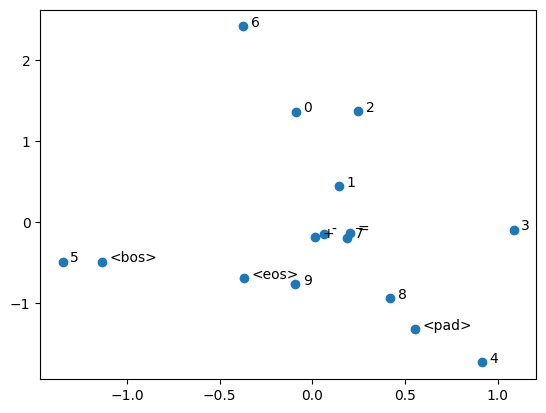

In [31]:
# TODO: Your code here.
embedding = nn.Embedding(len(vocab), 2)

# embed all tokens of our vocabulary
x = torch.arange(len(vocab))
emb = embedding(x).detach().cpu().numpy()

plt.scatter(emb[:, 0], emb[:, 1]);
for i, token in enumerate(vocab.tokens):
    plt.annotate(token, (emb[i,0]+0.04, emb[i,1]))

As always, we need to balance the complexity of our networks: a larger embedding will increase the number of parameters in our model, but increase the risk of overfitting.

**(j) Would this 2-dimensional embedding space be large enough for our problem?<span style="float:right"> (1 point)</span>**

Integer numbers could be represented in a single dimension. Using the same dimension for math operations might not be very intuitive, so adding a 2nd dimension would probably be helpful. Thus a 2-dimensional embedding space may be enough for such a simple problem. In reality though, features are often scattered across multiple dimensions, so it could happen that in practice more dimensions result in a better performance.

Instead of using an embedding, we could also use a simple one-hot encoding to map the words in the vocabulary to feature vectors. However, practical applications of natural language processing never do this. Why not?

**(k) Explain the practical advantage of embeddings over one-hot encoding.<span style="float:right"> (1 point)</span>**

There are a few advantage of embeddings compared to one-hot encodings:
* Embeddings are constant in dimensionality, regardless of the amount of unique tokens
* Embeddings are able to capture meaning within data, as the dimensionality reduction forces the network to represent a pattern in the data meaningfully. In contrast, one-hot encodings are all orthogonal and therefore they don't represent any inherent relationship between tokens.
* For neural networks, a continuous input is often better for the optimisation and gradients, one-hot encodings are by definition binary.

## 6.3 `torch.nn.Transformer` (8 points)

<div style="float: left"><a href="https://cs.ru.nl/~gvtulder/vaswani-fig-1-highlight.png"><img src="https://cs.ru.nl/~gvtulder/vaswani-fig-1-highlight.png" width="300"></a></div>

We now have all required inputs for our transformer.

Consult the documentation for the [`torch.nn.Transformer`](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) class of PyTorch. This class implements a full Transformer as described in ["Attention Is All You Need"](https://arxiv.org/pdf/1706.03762.pdf), the paper that introduced this architecture.

The `Transformer` class implements the main part of the of the Transformer architecture, shown highlighted in the image on the left (see also Fig. 1 in "Attention Is All You Need").

For a given input sequence, it applies one or more encoder layers, followed by one or more decoder layers, to compute an output sequence that we can then process further.

Because the `Transformer` class takes care of most of the complicated parts of the model, we can concentrate providing the inputs and outputs: the grayed-out areas in the image.

Check out the parameters for the `Transformer` class and the inputs and outputs of its `forward` function.
<br style="clear: both">

**(a) Which parameter of the `Transformer` class should we base on our embedding?<span style="float:right"> (1 point)</span>**

The `torch.nn.Transformer()` has an attribute `d_model` that describes the expected dimensionality of each input to the encoder / decoder. The expected dimensionality of the input is equivalent to the dimension of the embedding vectors.

**(b) Given fixed input and output dimensions, which parameters of the `Transformer` can we use to change the complexity of our network?<span style="float:right"> (1 point)</span>**

There are a number of parameters that determine the complexity of the `torch.nn.Transformer()`. They are:

* `nhead` the number of attention heads used
* `num_encoder_layers` the number of layers in the transformer encoder
* `num_decoder_layers` the number of layers in the transformer decoder
* `dim_feedforward` the dimensionality of the fully connected layers

**(c) When using the `Transformer` class, where should we use the masks that we defined earlier?<span style="float:right"> (1 point)</span>**

Transformers offer various ways to mask the data. The padding mask that we defined in 6.2 (c) refers to the `src_key_padding_mask` of the torch transformer (masking irrelevant tokens so that they are not attended), while the square subsequent mask refers to the `tgt_mask` parameter (initroducing causality into the decoder).

### Building a network

**(d) Complete the code for the TransformerNetwork.<span style="float:right"> (5 points)</span>**

Construct a network with the following architecture (see the image in the previous section for an overview):
1. An embedding layer that embeds the input tokens into a space of size `dim_hidden`.
2. A dropout layer (not shown in the image).
3. A [Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) with the specified parameters (`dim_hidden`, `num_heads`, `num_layers`, `dim_feedforward`, and `dropout`).<br>Note: you will need to pass `batch_first=True`, to indicate that the first dimension runs over the batch and not over the sequence.
4. A final linear prediction layer that takes the output of the transformer to `dim_vocab` possible classes.

Don't worry about positional encoding for now, we will add that later.

The `forward` function should generate the appropriate masks and combine the layers defined in `__init__` to compute the output.

In [32]:
class TransformerNetwork(torch.nn.Module):
    def __init__(self,
                 dim_vocab=len(vocab), padding_token=vocab['<pad>'],
                 num_layers=2, num_heads=4, dim_hidden=64, dim_feedforward=64,
                 dropout=0.01, positional_encoding=False):
        super().__init__()
        self.padding_token = padding_token
        # TODO: Your code here.
        self.embedding    = nn.Embedding(len(vocab), dim_hidden)
        self.dropout      = nn.Dropout(dropout)
        self.transformer  = torch.nn.Transformer(
            d_model=dim_hidden, nhead=num_heads, num_encoder_layers=num_layers,
            num_decoder_layers=num_layers, dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True)
        self.predict      = nn.Linear(dim_hidden, dim_vocab)
        if positional_encoding:
            self.pos_encoding = PositionalEncoding(num_hiddens=dim_hidden)
        else:
            self.pos_encoding = torch.nn.Identity()


    def forward(self, src, tgt):
        # Compute embedding
        src_embedding = self.embedding(src)
        tgt_embedding = self.embedding(tgt)

        # Apply positional encoding
        src_embedding = self.pos_encoding(src_embedding)
        tgt_embedding = self.pos_encoding(tgt_embedding)

        # Apply dropout
        src_embedding = self.dropout(src_embedding)
        tgt_embedding = self.dropout(tgt_embedding)

        # Construct masks
        src_key_padding_mask = generate_padding_mask(src, self.padding_token)
        tgt_key_padding_mask = generate_padding_mask(tgt, self.padding_token)

        tgt_mask = generate_square_subsequent_mask(tgt.shape[1])

        # Feed through transformer
        output = self.transformer(src_embedding, tgt_embedding,
                                  src_key_padding_mask=src_key_padding_mask, # Ignore padding on encoder side
                                  tgt_key_padding_mask=tgt_key_padding_mask, # Ignore padding on decoder side
                                  memory_key_padding_mask=src_key_padding_mask, # Ignore padding in cross attention from encoder to decoder
                                  tgt_mask=tgt_mask) # Prevent decoder from cheating by looking into the future. 
        
        # Predict
        output = self.predict(output)

        return output

**(e) Try the transformer with an example batch.**

In [33]:
net = TransformerNetwork(dim_feedforward=72)
x, y = next(iter(train_loader))
y_prev = shift_targets(y)

print('x.shape', x.shape)
print('y.shape', y.shape)
print('y_prev.shape', y_prev.shape)

y_pred = net(x, y_prev)
print('y_pred.shape', y_pred.shape)

# check the shape against what we expected
np.testing.assert_equal(list(y_pred.shape), [y.shape[0], y.shape[1], len(vocab)])

x.shape torch.Size([125, 9])
y.shape torch.Size([125, 5])
y_prev.shape torch.Size([125, 5])
y_pred.shape torch.Size([125, 5, 16])


We can convert these predictions to tokens (but they're obviously random):

In [34]:
print(decode_tokens(torch.argmax(y_pred, dim=2))[:5])


[['5' '<bos>' '=' '<bos>' '=']
 ['5' '5' '5' '=' '5']
 ['5' '9' '2' '9' '9']
 ['9' '5' '9' '9' '9']
 ['<bos>' '5' '9' '=' '9']]


In [35]:
# Check that the transformer is defined correctly
assert isinstance(net.embedding, torch.nn.Embedding)
assert isinstance(net.dropout, torch.nn.Dropout)
assert isinstance(net.transformer, torch.nn.Transformer)
assert isinstance(net.predict, torch.nn.Linear)
# Check parameters of transformer
assert net.transformer.d_model == 64
assert net.transformer.nhead == 4
assert net.transformer.batch_first == True
assert net.transformer.encoder.num_layers == 2
assert net.transformer.decoder.num_layers == 2
assert net.transformer.encoder.layers[0].linear1.out_features == 72
assert net.dropout.p == 0.01
assert net.transformer.encoder.layers[0].dropout.p == 0.01
# Check that the forward function behaves correctly
net.train(False)
assert torch.all(torch.isclose( \
            net(x, y_prev), \
            net(torch.cat((x,torch.tensor(vocab['<pad>']).expand(x.shape[0], 5)), axis=1), y_prev), atol=1e-5)), \
       "Adding padding to x should not affect the output of the network. Check src_key_padding_mask and memory_key_padding_mask. The former controls self attention to padding tokens in the encoder, the latter controls cross attention from decoder to encoder."
assert torch.all(torch.isclose( \
            net(x, y_prev), \
            net(x, torch.cat((y_prev,torch.tensor(vocab['<pad>']).expand(y.shape[0], 5)), axis=1))[:,:-5], atol=1e-5)), \
       "Adding padding to y should not affect the output of the network. Check tgt_key_padding_mask."
assert torch.all(torch.isclose( \
            net(x, y_prev)[:,:2], \
            net(x, y_prev[:,:2]), atol=1e-5)), \
       "The presence of later tokens in y should not affect the output for earlier tokens. Check tgt_mask."
assert torch.all(torch.isclose( \
            net(x, y_prev), \
            net(torch.flip(x, [1]), y_prev), atol=1e-5)), \
       "Order of x should not matter for a transformer network. Check src_mask."
assert not torch.all(torch.isclose( \
            net(x, torch.flip(y_prev, [1])), \
            torch.flip(net(x, y_prev), [1]), atol=1e-5)), \
       "Order of y should matter for a transformer network. Check tgt_mask."

## 6.4 Training (10 points)

### Training loop

We will base the training code on last week's code. A complication in computing the loss and accuracy are the padding tokens. So, before we work on the training loop itself, we need to update the `accuracy` function so it ingores these `<pad>` tokens. Let's do this in a generic way

**(a) Copy the `accuracy` function from last week, and add a parameter `ignore_index`. The tokens with `true_y == ignore_index` should be ignored.<span style="float:right"> (1 point)</span>**

Hint: you can select elements from a tensor with `some_tensor[include]` where `include` is a tensor of booleans.

In [36]:
def accuracy(pred_y, true_y, ignore_index=None):
    # Computes the mean accuracy, disregarding ignore_index`.
    if ignore_index is not None:
        mask = true_y != ignore_index
        pred_y = pred_y[mask]
        true_y = true_y[mask]

    if pred_y.shape[1] == 1:
        # binary classification
        correct = (pred_y[:, 0] > 0).to(true_y.dtype) == true_y
    else:
        # multi-class classification
        correct = pred_y.argmax(dim=1) == true_y
    return int(correct.sum()) / len(true_y)

In [37]:
# Test the accuracy function.
assert accuracy(torch.tensor([[1,0,0],[0.4,0.5,0.1],[0,1,0],[0.4,0.1,0.5]]), torch.tensor([0,1,2,2]), 1) == 2/3
assert accuracy(torch.tensor([[1,0,0],[0.4,0.5,0.1],[0,1,0],[0.4,0.1,0.5]]), torch.tensor([0,1,2,2]), 2) == 1
assert accuracy(torch.tensor([[1,0,0],[0.4,0.5,0.1],[0,1,0],[0.4,0.1,0.5]]), torch.tensor([0,1,2,2]), 3) == 3/4
assert accuracy(torch.tensor([[1,0,0],[0.4,0.5,0.1],[0,1,0],[0.4,0.1,0.5]]), torch.tensor([2,2,1,2]), 2) == 1

**(b) Write a training loop for the transformer model.<span style="float:right"> (4 points)</span>**

See last week's assignment for inspiration.
The code is mostly the same with the following changes:
 * The cross-entropy loss function and accuracy should ignore all `<pad>` tokens. (Use `ignore_index`, see the [documentation of CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).)
 * The network expects `y_prev` as an extra input.
 * The output of the network contains a batch of N samples, with maximum length L, and gives logits over C classes, so it has size (N,L,C). But `CrossEntropyLoss` and `accuracy` expect a tensor of size (N,C,L). You can use [torch.Tensor.transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html) to change the output to the right shape.

In [38]:
class Plotter:
    """For plotting data in animation."""
    # Based on d2l.Animator
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a function to capture arguments
        def config_axes():
            axis = self.axes[0]
            axis.set_xlabel(xlabel), axis.set_ylabel(ylabel)
            axis.set_xscale(xscale), axis.set_yscale(yscale)
            axis.set_xlim(xlim),     axis.set_ylim(ylim)
            if legend:
                axis.legend(legend)
            axis.grid()
        self.config_axes = config_axes
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Metrics:
    """Accumulate mean values of one or more metrics."""
    def __init__(self, n):
        self.count = 0
        self.sum = (0,) * n
    def add(self, count, *values):
        self.count += count
        self.sum = tuple(s + count * v for s,v in zip(self.sum,values))
    def mean(self):
        return tuple(s / self.count for s in self.sum)
    
def evaluate(net, test_loader, loss_function=torch.nn.CrossEntropyLoss(), device=device):
    """
    Evaluate a model on the given dataset.
    Return loss, accuracy
    """
    with torch.no_grad():
        net.eval()
        metrics = Metrics(2)
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            y_prev = shift_targets(y)
            pred_y = net(x, y_prev)
            loss = loss_function(pred_y.transpose(1,2), y)
            acc = accuracy(pred_y, y, ignore_index=vocab['<pad>'])
            metrics.add(len(y), loss.item(), acc)
        return metrics.mean()

In [39]:
def train(net, data_loaders, num_epochs=100, lr=0.001, optimizer=torch.optim.Adam, device=device):
    """
    Train a network on the given data set.
    After every epoch compute validation loss and accuracy.
    """
    # TODO: Your code here.
    # Hint: See assignment 4.
    net.to(device)
    train_loader = data_loaders['train']
    num_batches = len(train_loader)
    optimizer = optimizer(net.parameters(), lr=lr)
    loss_function = torch.nn.CrossEntropyLoss()
    plotter = Plotter(xlabel='epoch', xlim=[1, num_epochs],
                      legend=['train loss', 'train acc', 'val loss', 'val acc'])
    start_time = time.time()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        net.train()
        metrics = Metrics(2)
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            y = y.to(device)
            y_prev = shift_targets(y)
            pred_y = net(x, y_prev)
            loss = loss_function(pred_y.transpose(1, 2), y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                acc = accuracy(pred_y, y, ignore_index=vocab['<pad>'])
                metrics.add(len(y), loss.item(), acc)
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                train_loss, train_acc = metrics.mean()
                plotter.add(epoch + (i + 1) / num_batches, (train_loss, train_acc, None, None))
        val_loss, val_acc = evaluate(net, data_loaders['val'], loss_function=loss_function, device=device)
        plotter.add(epoch + 1, (None, None, val_loss, val_acc))
    train_loss, train_acc = metrics.mean()
    train_time = time.time() - start_time
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'val loss {val_loss:.3f}, val acc {val_acc:.3f}')
    print(f'{metrics.count * num_epochs / train_time:.1f} examples/sec '
          f'on {str(device)}')

### Experiment

**(c) Train a transformer network. Use 100 epochs with a learning rate of 0.001<span style="float:right"> (no points)</span>**

train loss 1.019, train acc 0.605, val loss 1.690, val acc 0.440
3659.1 examples/sec on cpu


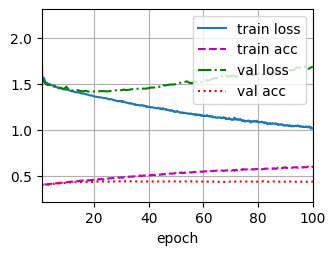

In [40]:
net = TransformerNetwork()
train(net, data_loaders, num_epochs=100, lr=0.001)

**(d) Briefly discuss the results. Has the training converged? Is this a good calculator?<span style="float:right"> (1 point)</span>**

This is a very poor calculator as the validation accuracy is worse than chance at 43.6%. It doesn't seem like the training has converged yet as the the train loss is still decreasing and hasn't levelled out yet. However it looks like the network may be starting to overfit because the validation loss is increasing after an initial drop.

**(e) Run the trained network with input `"123+123"` and `"321+321"`.<span style="float:right"> (1 point)</span>**

In [41]:
np.set_printoptions(linewidth=200)
def predict(net, q, a):
    # Run net to predict the output given the input `q` and y_prev based on `a`.
    # Return predicted y
    q = torch.tensor(pad_or_trim(tokenize_and_encode(q), 2*complexity+3)).unsqueeze(0)
    a = torch.tensor(pad_or_trim(tokenize_and_encode(a), complexity+2)).unsqueeze(0)
    y_prev = shift_targets(a)
    with torch.no_grad():
        net.eval()
        pred_y = net(q, y_prev)
    return pred_y

for src, tgt in [('123+123', '246'), ('321+321', '642')]:
    print(f'For {src}={tgt}')
    y_pred = predict(net, src, tgt)
    first = y_pred[0]
    print(first)
    most_probable = torch.argmax(first, 1)
    print('  Most Probable indices', most_probable)
    print('  Decoded', decode_tokens(most_probable))
    print('  Pretty: ' + ''.join(decode_tokens(most_probable)))

For 123+123=246
tensor([[ -8.4386,  -0.8281,  -5.4316,   1.4194,   2.9509,   4.6788,   3.7779,
           3.1972,   0.9710,   1.3220,   0.9842,  -0.6270,  -8.9443,  -5.8506,
          -8.1154,  -8.4006],
        [-12.3719,  -8.2244,   1.8477,   0.8369,   3.0697,   3.5785,   3.4350,
           3.7305,  -2.1240,   1.4117,   1.6794,  -0.2560, -12.6761,  -5.3188,
         -11.6388, -11.6288],
        [ -5.9556,  -4.6204,  -2.7006,  -0.5771,   0.8332,   2.9586,   4.2669,
           4.9000,   0.3325,   2.9850,  -1.0061,  -1.0782,  -5.9508,  -2.3627,
          -8.4241,  -5.2852],
        [ -3.5844,  -3.0461,  -1.4554,  -1.9503,   1.7475,   3.3329,   2.1905,
           1.1986,  -2.7255,   1.5173,  -2.4445,  -2.1394,  -3.6216,   8.0438,
          -3.1113,  -2.6692],
        [  2.7132,   0.2959,   1.8889,   0.4256,   0.8163,   1.8464,   1.5978,
          -0.1826,  -3.0893,  -3.7585,   1.6219,  -4.3490,   2.6499,   0.0233,
          17.0374,   2.5332]])
  Most Probable indices tensor([ 5,  7,  7,

**(f) Compare the predictions for the first element of y with the two different inputs. Can you explain what happens?<span style="float:right"> (1 point)</span>** <span style="color:red">??</span>

Hmm, I'm not sure what is happening here, there doesn't seem to be a consistent pattern that I can seen. The first sample outputs 123+123=355 and the second sample outputs 321+321 = 333, both of which are incorrect. These additions don't require any carry operations so that shouldn't be the cause of the problem... It's probably caused by a lack of positional encodings such that the model doesn't know which digit of the first argument to add to which digit of the second argument, and which digit in the output the result corresponds to.

**(g) Does the validation accuracy estimate how often the model is able to answers formulas correctly? Explain your answer.<span style="float:right"> (1 point)</span>** <span style="color:red">??</span>

**TODO: Come back to this**

**(h) If the forward function takes the shifted output `y_prev` as input, how can we use it if we don't know the output yet?<span style="float:right"> (1 point)</span>**

We should be able to feed in the `SOS` token to the decoder as the initial input `y_prev` which will then output the first predicted token `y_1`. We can then feed `<SOS>, y_1` into the decoder again at the next step to produce the next output `y_2`, etc in an autoregressive manner. Of course you wouldn't do this during training, but only during inference.

## 6.5 Positional encoding (5 points)

We did not yet include positional encoding in the network.
PyTorch does not include such an encoder. So, here we define such a module ourselves:

In [42]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, max_len=100):
        super().__init__()
        # Create a long enough matrix of position encodings P
        positions = torch.arange(max_len, dtype=torch.float32)
        freqs = torch.pow(max_len, (1 + 2 * torch.arange(num_hiddens / 2)) / num_hiddens)
        X = positions[:,None] / freqs[None,:]
        self.P = torch.zeros((max_len, num_hiddens))
        self.P[:, 0::2] = torch.sin(X)
        self.P[:, 1::2] = torch.cos(X)

    def forward(self, X):
        return X + self.P[None, :X.shape[1], :].to(X.device)

**(a) Add positional encoding to the TransformerModel.<span style="float:right"> (point given in earlier question)</span>**

... see 6.3 (d)

**(b) Construct and train a network with positional encoding<span style="float:right"> (1 point)</span>**

In [43]:
net_pos = TransformerNetwork(positional_encoding=True)

**(c) How does the performance of a model with positional encoding compare to a model without?<span style="float:right"> (1 point)</span>**

train loss 0.133, train acc 0.953, val loss 0.127, val acc 0.960
3800.9 examples/sec on cpu


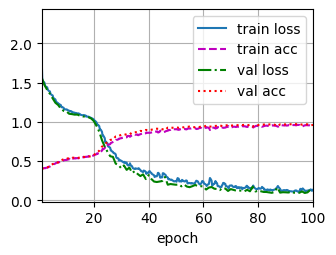

In [44]:
train(net_pos, data_loaders, num_epochs=100, lr=0.001)

The models performs significantly better with positional encoding, with a validation accuracy of 98%, a huge performance increase over the original network. Additionally it does not seem to be overfitting.

**(d) Run the trained network with input `"123+123"` and `"321+321"`.<span style="float:right"> (no points)</span>**

In [45]:
for src, tgt in [('123+123', '246'), ('321+321', '642')]:
    print(f'For {src}={tgt}')
    y_pred = predict(net_pos, src, tgt)
    first = y_pred[0]
    most_probable = torch.argmax(first, 1)
    print('  Most Probable indices', most_probable)
    print('  Decoded', decode_tokens(most_probable))
    print('  Pretty: ' + ''.join(decode_tokens(most_probable)))

For 123+123=246
  Most Probable indices tensor([ 4,  6,  8, 13, 14])
  Decoded ['2' '4' '6' '<eos>' '<pad>']
  Pretty: 246<eos><pad>
For 321+321=642
  Most Probable indices tensor([ 8,  6,  4, 13, 14])
  Decoded ['6' '4' '2' '<eos>' '<pad>']
  Pretty: 642<eos><pad>


**(e) Compare the predictions for the first element of y with what you found earlier. Can you explain what happens?<span style="float:right"> (1 point)</span>**

With positional encoding the network now outputs the correct answers for both tests. I think this is because now it realizes that it needs to add the digit at each index of one argument to the corresponding digit at the same index in the second argument to produce the output digit at that same index.

**(f) Explain in your own words why positional encoding is used in transformer networks.<span style="float:right"> (1 point)</span>**

Positional encoding is used in transformers because unlike RNNs or LSTMs, the position of the input elements is not inherently enforced by the architecture of the network. The standard transformer does not distinguish between two input sequences with the same tokens but arranged in different orders. Thus if we are dealing with data where position information is important, we must add positional encodings. 

**(g) Look at the learning curve. Can you suggest a way to improve the model?

Overall the model looks to train well and converge to a good solution. The training and validation loss seem to plateau right in the epochs leading up to epcoh 20, before dropping quickly again after epoch 20.  This plato may reflect many things, but it could mean that the model found a local minimum in the loss landscape, before Adam escaped it. To relate this back to the dataset that we are using, it might be that the model understood how to add numbers at that point, but did not learn subtraction, or vice versa. It could also be that this is a sub-group of 'simple' problems, where element wise operations are possible, so the questions where no element-wise addition leads to a number above 9 / no subtraction resulted in a number lower than zero. As this is just speculation, it would be interesting to find out why this "hump" in the training occurs with experimental data. Perhaps also simply increasing the dropout rate may help the model learns to generalize earlier on in the training process.

**(h) Optional: if time permits, try to train an even better model**

Time does not permit :'(

## 6.6 Predicting for new samples (5 points)

Predicting an output given a new sample requires an appropriate search algorithm (see [d2l chapter 10.8](https://d2l.ai/chapter_recurrent-modern/beam-search.html)). Here, we will implement the simplest form: a greedy search algorithm that selects the token with the highest probability at each time step.

**(a) Describe this search strategy in pseudo-code.<span style="float:right"> (1 point)</span>**

At each time step $t'$ we select the token with the highest conditional probabiilty. So we can iterate through the time steps and perform the following calculation:

$$
y_{t'} = \text{argmax}_{y\in \mathcal{Y}} P(y|y_1,\dots,y_{t'-1},\boldsymbol{c})
$$

Once the model outputs `<eos>` (or we reach the maximum length $T'$) the output sequence is completed. Then we can concatenate all the output tokens to get a complete output sequence.

**(b) Implement a greedy search function to predict a sequence using `net_pos`.<span style="float:right"> (2 points)</span>**

In [46]:
def predict_greedy(net, src, length):
    # Run net to predict the output given the input `q` and y_prev based on `a`.
    # Return predicted y
    src = torch.tensor(pad_or_trim(tokenize_and_encode(src), 2*complexity+3)).unsqueeze(0)
    print(src)
    y_prev = torch.tensor([[vocab['<bos>']]])
    predicted_sequence = []
    for i in range(length):
        with torch.no_grad():
            net.eval()
            pred_y = net(src, y_prev)
            predicted_token = torch.argmax(pred_y[0, -1])
            predicted_sequence.append(predicted_token.item())
            y_prev = torch.cat((y_prev, predicted_token.unsqueeze(0).unsqueeze(0)), axis=1)
    return predicted_sequence

In [47]:
predicted_sequence = predict_greedy(net_pos, '123+123', 6)
print(decode_tokens(predicted_sequence))

tensor([[ 3,  4,  5,  0,  3,  4,  5, 13, 14]])
['2' '4' '6' '<eos>' '<pad>' '<pad>']


**(c) Does this search strategy give a high-quality prediction? Why, or why not?<span style="float:right"> (1 point)</span>**

In this case the greedy search strategy performs quite well as it gives the corred answer by greedily selecting the most likely tokens at each time step. For calculations where we don't need to "look" ahead to see if there are carry bits, this strategy might work well because the output at a given position only depends on the digits at that position. For calculations with a carry bit this may not work so well...

**(d) What alternative search strategy could we use to improve the predictions? Why would this help?<span style="float:right"> (1 point)</span>**

We could use beam search to search for the most likely sequence, rather than the most likely tokens by maximizing this expression:

$$
\prod_{t'=1}^{T'}P(y_{t'}|y_1,...,y_{t'-1},\boldsymbol{c})
$$

This would likely improve the overall solutions because it can "look ahead" to consider various possible sequences and select that sequence with highest probability, which might be higher than the sequence generated by taking the most probable token at each timestep. This may be useful for calculations that require a carry operations.

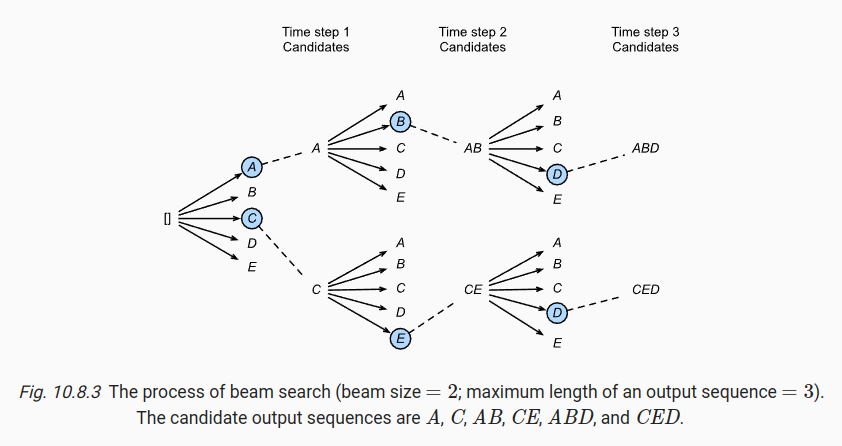

## 6.7 Discussion (4 points)

Last week, we looked at recurrent neural networks such as the LSTM. Both recurrent neural networks and transformers work with sequences, but in recent years the transformer has become more popular than the recurrent models.

**(a) An advantage of transformers over recurrent neural is that they can be faster to train. Why is that?<span style="float:right"> (1 point)</span>**

They are faster to train because we can process all the input tokens in parallel in a transformer, whereas RNNs and LSTMs must process input tokens sequentially.

**(b) Does this advantage also hold when predicting outputs for new sequences? Why, or why not?<span style="float:right"> (1 point)</span>**

No, this advantage does not hold, prediciting ouput tokens at inference time is a sequential operation in both architectures. This is because the predict each output token we require the previous output token to perform autoregession. The next output token is conditioned on those tokens that came before it.

**(c) Why is positional encoding often used in transformers, but not in convolutional or recurrent neural networks?<span style="float:right"> (1 point)</span>**

Positional encoding is used in transformers because it has no other mechanism to distinguish between input sequences with identical tokens but ordered differently whereas RNNs and convolutional networks process information sequentially and thus implicitly define an ordering.

The structure of a recurrent neural network makes it very suitable for online predictions, such as real-time translation, because it only depends on prior inputs. You can design an architecture where the RNN produces an output token for every input token given to it, and it can produce that output without having to wait for the rest of the input.

Note: 'online' means producing outputs continuously as new input comes in, as opposed to collecting a full dataset and analyzing it afterwards, it has nothing to do with the internet.

**(d) How would a transformer work in an online application? Do you need to change the architecture?<span style="float:right"> (1 point)</span>**

To work in an online procedure as described aboce, the transformer architecture would need to be complemented with a causal attention mask that simulates the recurrent input by hiding empty tokens and adding each newly predicted token to the input of the next call, like in the inference loop above. Technically speaking, the transformer is still taking a full sequence as an input, but by using the workaround with the attention mask and updating the input with each new token, the transformer architecture could be used 'live'.

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 47 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 4f237eb / 2024-10-08</span>